# Testing new features

Trying to test new features, and new ways of defining 'progress'


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import stats_helper_files as stat
from sklearn.feature_selection import f_classif
from scipy.stats import mannwhitneyu, ks_2samp


# Inputs
external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"

In [6]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)
print('Total number of schools in external spreadsheet:',len(df_ext))

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)
print('Total number of schools in internal spreadsheet:',len(df_int))

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))
print('Number of schools after joining:',len(df))

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]
print('Number of schools that had all science courses:',len(df))


Total number of schools in external spreadsheet: 2776
Total number of schools in internal spreadsheet: 1238
Number of schools after joining: 2776
Number of schools that had all science courses: 899


In [14]:
# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

# Defining it relative to the mean

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item]/df['exam_score|2014_'+item].mean() - df['exam_score|2013_'+item]/df['exam_score|2013_'+item].mean())

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item]/df['exam_score|2016_'+item].mean() - df['exam_score|2013_'+item]/df['exam_score|2013_'+item].mean())

# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0) 

# Trying a combination
df['combo'] = (df['std_q_cor']/df['std_q_cor'].mean()) + (df['std_ratio']/df['std_ratio'].mean())

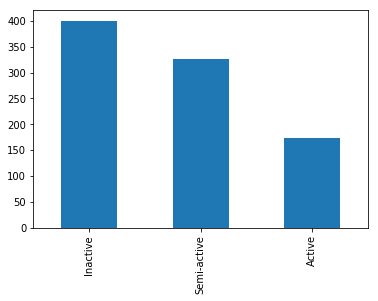

In [15]:
# Let's bin each school according to their activity on IP


bins = [-0.1, 0, 2,10000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = stat.bin_groups(df,'combo',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')
plt.savefig('distribution.png', format='png', dpi=300)


## Looking at all entries

Here we don't differentiate between groups and see impact on the whole population


,Feature,P val,Score
7,exam_improv_2013-2016_Physics,0.009612,0.146922
5,exam_improv_2013-2016_Mathematics,0.048872,0.122514
2,exam_improv_2013-2014_Chemistry,0.057314,0.119855
4,exam_improv_2013-2016_Biology,0.118442,0.106908
3,exam_improv_2013-2014_Physics,0.147477,0.102673
6,exam_improv_2013-2016_Chemistry,0.149542,0.102399
1,exam_improv_2013-2014_Mathematics,0.278065,0.089263
0,exam_improv_2013-2014_Biology,0.519174,0.073338


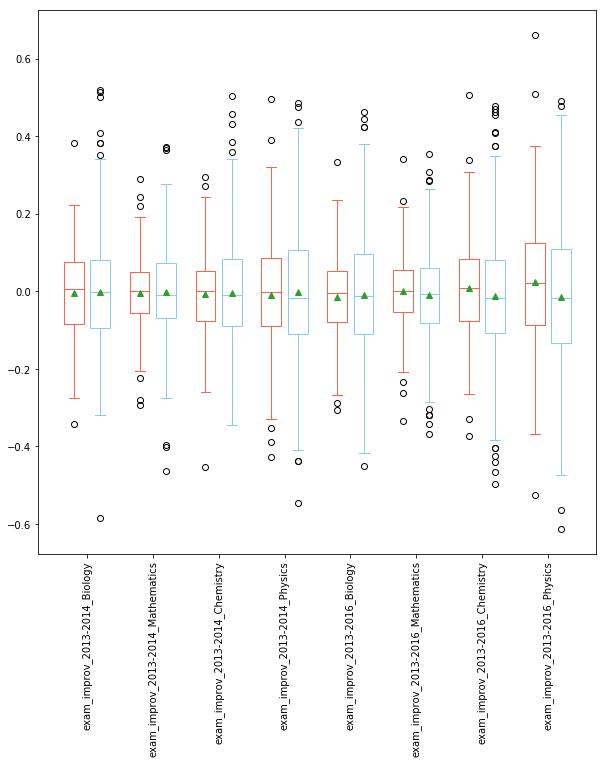

In [19]:
A = df[df['categories'] == 'Active'].filter(regex='exam_improv').values
B = df[df['categories'] == 'Inactive'].filter(regex='exam_improv').values

def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False,showmeans=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)

draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

# ANOVA test
score,p_val = f_classif(df.filter(regex='exam_improv'),df['categories'])
pd.DataFrame({'Keys':df.filter(regex='exam_improv').columns,'Score':score,'P values':p_val}).sort_values('P values')

# Non parametric test
stat.non_parametric_test(df,df.filter(regex='exam_improv').columns,ks_2samp)


## Looking at the IDACI index

Evaluating for different IDACI indices

1.0    244
2.0    154
3.0     84
4.0     57
5.0     19
Name: IDACI, dtype: int64


558

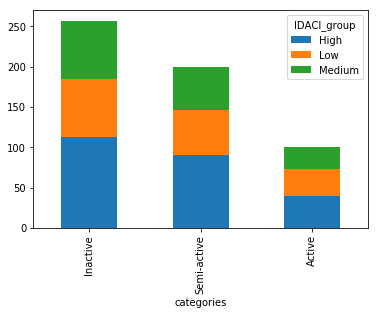

In [20]:
df['IDACI'] = [np.nan if item == 0 else item for item in df['IDACI']]

bin_val = df['IDACI'].value_counts()
print(bin_val)

# Anything with IDACI 1 set as High, IDACI 2 as Medium and IDACI 3,4,5 as Low
df['IDACI_group'] = df['IDACI']*0

store = []
for item in df['IDACI']:

    if item == 1.0:
        store.append('High')
    elif item == 2.0:
        store.append('Medium')
    elif item > 2:
        store.append('Low')
    else:
        store.append(np.nan)
        
df['IDACI_group'] = store

df4=df.groupby(['categories','IDACI_group']).size()
df4=df4.unstack()
df4.plot(kind='bar', stacked=True)

df['IDACI'].count()

Difference between active and inactive groups at low IDACI numbers
Checking if any differences is significant


,Feature,P val,Score
7,exam_improv_2013-2016_Physics,0.080058,984.0
5,exam_improv_2013-2016_Mathematics,0.097791,1000.0
6,exam_improv_2013-2016_Chemistry,0.108952,1009.0
4,exam_improv_2013-2016_Biology,0.325590,1122.0
0,exam_improv_2013-2014_Biology,0.353387,1133.0
3,exam_improv_2013-2014_Physics,0.361113,1136.0
1,exam_improv_2013-2014_Mathematics,0.397876,1150.0
2,exam_improv_2013-2014_Chemistry,0.405886,1153.0


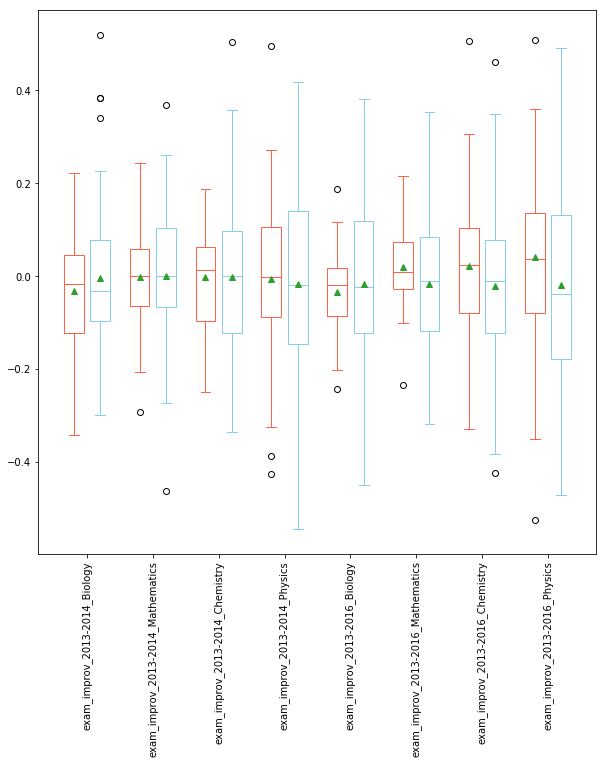

In [24]:
print('Difference between active and inactive groups at low IDACI numbers')

df_plot = df[df['IDACI_group']=='Low']

A = df_plot[df_plot['categories'] == 'Active'].filter(regex='exam_improv').values
B = df_plot[df_plot['categories'] == 'Inactive'].filter(regex='exam_improv').values

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)

draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

print('Checking if any differences is significant')

# Non parametric test
stat.non_parametric_test(df_plot,df_plot.filter(regex='exam_improv').columns,mannwhitneyu)

Difference between active and inactive groups at medium IDACI numbers
Checking if any differences is significant


,Feature,P val,Score
1,exam_improv_2013-2014_Mathematics,0.022759,747.0
2,exam_improv_2013-2014_Chemistry,0.034132,770.0
3,exam_improv_2013-2014_Physics,0.054730,799.0
4,exam_improv_2013-2016_Biology,0.123969,857.0
5,exam_improv_2013-2016_Mathematics,0.161949,879.0
6,exam_improv_2013-2016_Chemistry,0.291538,936.0
0,exam_improv_2013-2014_Biology,0.357686,960.0
7,exam_improv_2013-2016_Physics,0.380855,968.0


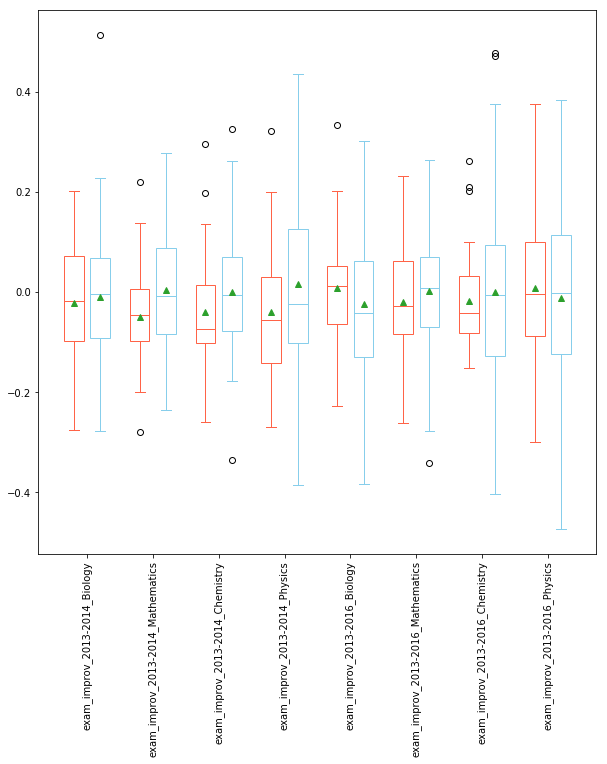

In [28]:
print('Difference between active and inactive groups at medium IDACI numbers')

df_plot = df[df['IDACI_group']=='Medium']

A = df_plot[df_plot['categories'] == 'Active'].filter(regex='exam_improv').values
B = df_plot[df_plot['categories'] == 'Inactive'].filter(regex='exam_improv').values

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)

draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

print('Checking if any differences is significant')

# Non parametric test
stat.non_parametric_test(df_plot,df_plot.filter(regex='exam_improv').columns,mannwhitneyu)

Difference between active and inactive groups at high IDACI numbers
Checking if any differences is significant


,Feature,P val,Score
5,exam_improv_2013-2016_Mathematics,0.058511,1882.0
7,exam_improv_2013-2016_Physics,0.106835,1960.0
1,exam_improv_2013-2014_Mathematics,0.117928,1974.0
4,exam_improv_2013-2016_Biology,0.259256,2104.0
6,exam_improv_2013-2016_Chemistry,0.271503,2113.0
3,exam_improv_2013-2014_Physics,0.279127,2118.5
0,exam_improv_2013-2014_Biology,0.423452,2213.0
2,exam_improv_2013-2014_Chemistry,0.467735,2240.0


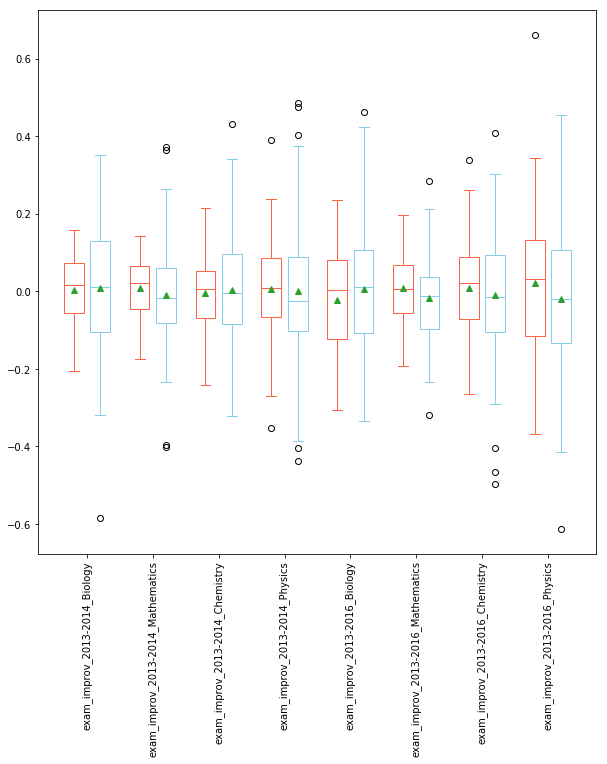

In [30]:
print('Difference between active and inactive groups at high IDACI numbers')

df_plot = df[df['IDACI_group']=='High']

A = df_plot[df_plot['categories'] == 'Active'].filter(regex='exam_improv').values
B = df_plot[df_plot['categories'] == 'Inactive'].filter(regex='exam_improv').values

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)

draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

print('Checking if any differences is significant')

# Non parametric test
stat.non_parametric_test(df_plot,df_plot.filter(regex='exam_improv').columns,mannwhitneyu)

## FSM Groups

Looking at free school meals here


In [31]:
# Let's first remove the schools that have a FSM of 0% because, it is unreliable

df['PercentageFSM'] = [np.nan if item == 0 else item for item in df['PercentageFSM']]

print('Number of remaining schools:',len(df))

# Bin into identical categories
N_categories = 3;
labels = ['Low','Medium','High']

df['FSM_group'], bins = pd.qcut(df['PercentageFSM'], N_categories, labels = labels, retbins = True)

print(bins)

Number of remaining schools: 899
[  0.3   3.9   7.4  44.1]


Difference between active and inactive groups for a low FSM group


,Feature,P val,Score
7,exam_improv_2013-2016_Physics,0.085340,1046.0
2,exam_improv_2013-2014_Chemistry,0.206310,1127.0
3,exam_improv_2013-2014_Physics,0.287424,1165.0
5,exam_improv_2013-2016_Mathematics,0.294416,1168.0
4,exam_improv_2013-2016_Biology,0.352957,1192.0
1,exam_improv_2013-2014_Mathematics,0.412558,1215.0
0,exam_improv_2013-2014_Biology,0.425840,1220.0
6,exam_improv_2013-2016_Chemistry,0.466135,1235.0


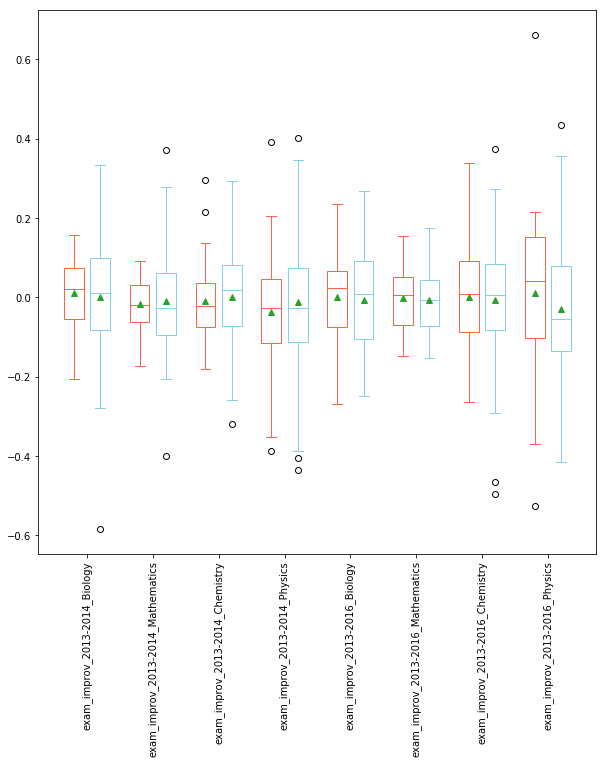

In [32]:
df_plot = df[df['FSM_group']=='Low']

A = df_plot[df_plot['categories'] == 'Active'].filter(regex='exam_improv').values
B = df_plot[df_plot['categories'] == 'Inactive'].filter(regex='exam_improv').values

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)
#

print('Difference between active and inactive groups for a low FSM group')
draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.feature_selection import f_classif

score,p_val = f_classif(df_plot.filter(regex='exam_improv'),df_plot['categories'])

pd.DataFrame({'Keys':df_plot.filter(regex='exam_improv').columns,'Score':score,'P values':p_val}).sort_values('P values')

stat.non_parametric_test(df_plot,df_plot.filter(regex='exam_improv').columns,mannwhitneyu)

Difference between active and inactive groups for a medium FSM group


,Feature,P val,Score
2,exam_improv_2013-2014_Chemistry,0.082056,935.0
0,exam_improv_2013-2014_Biology,0.085045,938.0
3,exam_improv_2013-2014_Physics,0.169340,1002.0
4,exam_improv_2013-2016_Biology,0.272093,1056.0
5,exam_improv_2013-2016_Mathematics,0.337833,1085.0
1,exam_improv_2013-2014_Mathematics,0.439422,1126.0
6,exam_improv_2013-2016_Chemistry,0.444543,1128.0
7,exam_improv_2013-2016_Physics,0.478015,1141.0


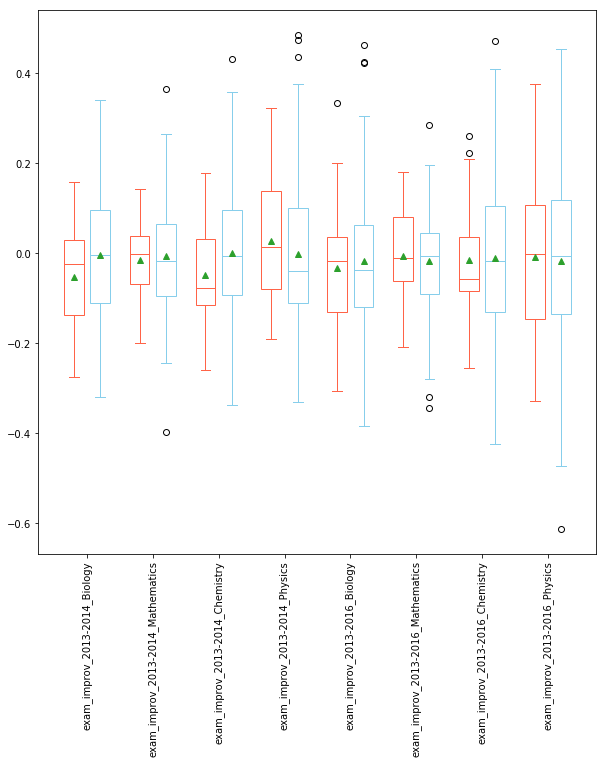

In [35]:
df_plot = df[df['FSM_group']=='Medium']

A = df_plot[df_plot['categories'] == 'Active'].filter(regex='exam_improv').values
B = df_plot[df_plot['categories'] == 'Inactive'].filter(regex='exam_improv').values

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)
#

print('Difference between active and inactive groups for a medium FSM group')
draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.feature_selection import f_classif

score,p_val = f_classif(df_plot.filter(regex='exam_improv'),df_plot['categories'])

pd.DataFrame({'Keys':df_plot.filter(regex='exam_improv').columns,'Score':score,'P values':p_val}).sort_values('P values')

stat.non_parametric_test(df_plot,df_plot.filter(regex='exam_improv').columns,mannwhitneyu)

Difference between active and inactive groups for a high FSM group


,Feature,P val,Score
7,exam_improv_2013-2016_Physics,0.078176,1495.0
6,exam_improv_2013-2016_Chemistry,0.108499,1531.0
5,exam_improv_2013-2016_Mathematics,0.177576,1592.0
4,exam_improv_2013-2016_Biology,0.298622,1670.0
3,exam_improv_2013-2014_Physics,0.340347,1693.0
2,exam_improv_2013-2014_Chemistry,0.344079,1695.0
1,exam_improv_2013-2014_Mathematics,0.374458,1711.0
0,exam_improv_2013-2014_Biology,0.415516,1732.0


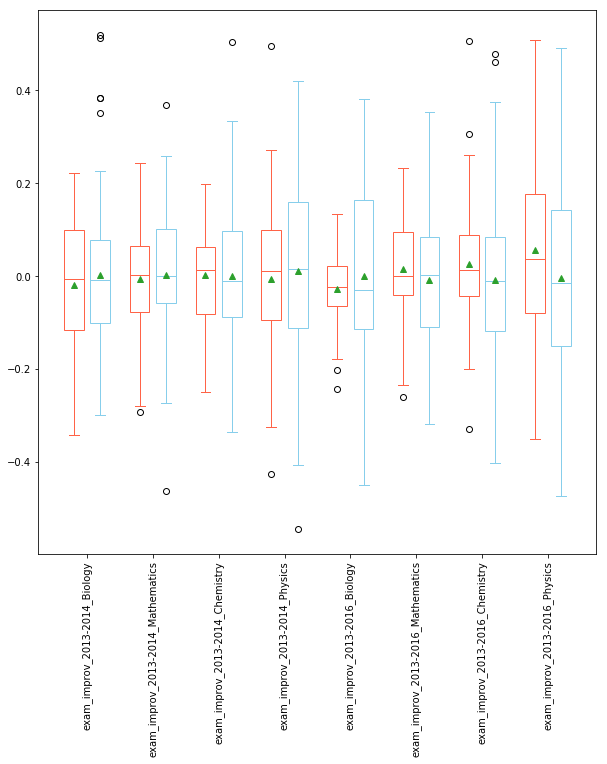

In [36]:
df_plot = df[df['FSM_group']=='High']

A = df_plot[df_plot['categories'] == 'Active'].filter(regex='exam_improv').values
B = df_plot[df_plot['categories'] == 'Inactive'].filter(regex='exam_improv').values

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)
#

print('Difference between active and inactive groups for a high FSM group')
draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")

from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.feature_selection import f_classif

score,p_val = f_classif(df_plot.filter(regex='exam_improv'),df_plot['categories'])

pd.DataFrame({'Keys':df_plot.filter(regex='exam_improv').columns,'Score':score,'P values':p_val}).sort_values('P values')

stat.non_parametric_test(df_plot,df_plot.filter(regex='exam_improv').columns,mannwhitneyu)